# 0 Look & Learn multistore

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()


In [ ]:
import subprocess
import os
import pandas as pd

# Komenda Git, aby znaleźć katalog główny repozytorium
repo_dir = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).strip().decode('utf-8')

# Lista plików (relative paths)
files_csv = [
    'data/raw/cosmetics/2019-Oct.csv',
    'data/raw/cosmetics/2019-Nov.csv',
    'data/raw/cosmetics/2019-Dec.csv',
    'data/raw/cosmetics/2020-Jan.csv',
    'data/raw/cosmetics/2020-Feb.csv'
]

# Tworzenie pełnych ścieżek do plików
full_paths = [os.path.join(repo_dir, file) for file in files_csv]

# Lista do przechowywania dataframe'ów
frame = []

# Wczytanie plików CSV
for file_path in full_paths:
    df_i = pd.read_csv(file_path)
    # Dodanie kolumny 'month' na podstawie nazwy pliku
    month = os.path.basename(file_path)[-7:-4]  # Wyciąganie miesiąca z nazwy pliku
    df_i['month'] = month
    frame.append(df_i)

# Łączenie wszystkich dataframe'ów w jeden
df = pd.concat(frame, ignore_index=True, sort=False)

# Szybka analiza dataframe'u
print("The dataframe has {} rows and {} columns.\n".format(df.shape[0], df.shape[1]))
print("Shown below are the first 3 rows of the dataframe:\n")
pd.set_option('display.max_columns', 100)
display(df.head(3))


The dataframe has 20692840 rows and 10 columns.

Shown below are the first 3 rows of the dataframe:



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month
0,2019-10-01 00:00:00 UTC,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,Oct
1,2019-10-01 00:00:03 UTC,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,Oct
2,2019-10-01 00:00:07 UTC,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,Oct


In [13]:
# data preparation

# step 1: select customers who purchased
df_sales = df.loc[df.event_type == 'purchase', :]

# step 2: drop "category_code", "brand", "product_id", "category_id", and "user_session"
df_sales = df_sales.drop(columns=['category_code', 'brand', 'product_id', 'category_id', 'user_session'])

# step 3: drop duplicates and negative price
df_sales = df_sales.drop_duplicates()
df_sales = df_sales.loc[df_sales["price"] > 0]  # using .loc to avoid the warning

# step 4: convert "event_time" to DateTime format
df_sales['event_time'] = pd.to_datetime(df_sales['event_time'])  # removing the deprecated argument

# Check for missing values
nullcolumns = df_sales.isnull().sum()
nullnumbers = len(nullcolumns[nullcolumns != 0])
print("After preprocessing, the dataframe has {} rows, {} columns, and {} null value.\n".format(df_sales.shape[0], df_sales.shape[1], nullnumbers))
display(df_sales.head(3))

After preprocessing, the dataframe has 908656 rows, 5 columns, and 0 null value.



,event_time,event_type,price,user_id,month
202,2019-10-01 00:06:35+00:00,purchase,5.32,474232307,Oct
204,2019-10-01 00:06:35+00:00,purchase,2.86,474232307,Oct
205,2019-10-01 00:06:35+00:00,purchase,2.38,474232307,Oct


In [14]:
# group the data by "user_id", and calcualte each customer's recency, frequency, and monetary value

# step 1: calculate "Recency", set Feb 2020 as the reference month, and use "month" as the unit
#d={"Oct":4,"Nov":3,"Dec":2,"Jan":1,"Feb":0}
#df_sales.loc[:,'Recency']=df_sales['month'].map(d)
df_sales["event_time"] = pd.to_datetime(df_sales["event_time"])
df_sales.loc[:,'Recency'] = (df_sales["event_time"].max() - df_sales["event_time"]).dt.days
df_R=df_sales.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})

# step 2: calculate "Frequency"
df_F=df_sales.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type":"Frequency"})

# step 3: calculate "Monetary"
df_M=df_sales.groupby('user_id')['price'].sum().reset_index().rename(columns={"price":"Monetary"})

# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF=pd.merge(df_R,df_F,on='user_id')
df_RFM=pd.merge(df_RF,df_M,on='user_id')

# step 5: remove outliers before K-Means clustering
conditions=np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
df_RFM2=df_RFM.loc[conditions,:]

df_RFM2.head(3)

,user_id,Recency,Frequency,Monetary
0,9794320,96,2,7.72
1,10079204,115,2,25.81
2,10280338,10,19,63.29


In [15]:
print("max Recency: ", df_RFM2['Recency'].max())
print("max Frequency: ",df_RFM2['Frequency'].max())
print("max Monetary: ",df_RFM2['Monetary'].max())


max Recency:  151
max Frequency:  41
max Monetary:  251.98000000000002


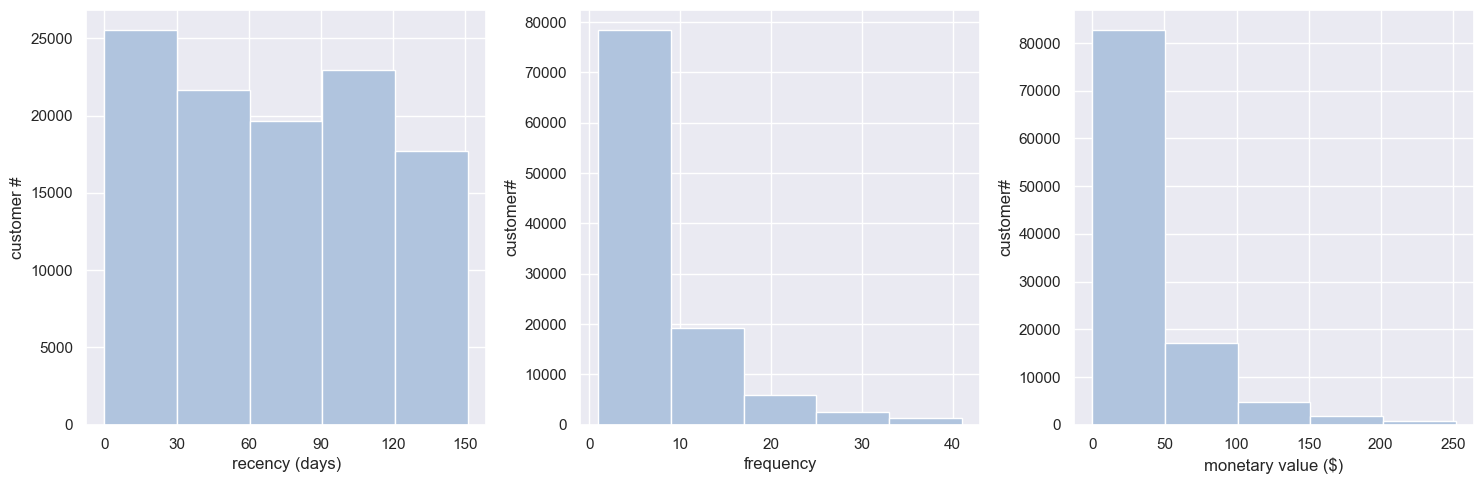

In [16]:
# visualize the distribution of "Recency", "Frequency", and "Monetary"
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

# plot "Recency"
ax1.hist(df_RFM2['Recency'],bins=5,color='lightsteelblue')
ax1.set_xticks(np.arange(0,151,30))
ax1.set_xlabel('recency (days)')
ax1.set_ylabel('customer #')

# plot "Frequency"
ax2.hist(df_RFM2['Frequency'],bins=5,color='lightsteelblue')
ax2.set_xlabel('frequency')
ax2.set_ylabel('customer#')

# plot "Monetary"
ax3.hist(df_RFM2['Monetary'],bins=5,color='lightsteelblue')
ax3.set_xlabel('monetary value ($)')
ax3.set_ylabel('customer#')

plt.tight_layout()


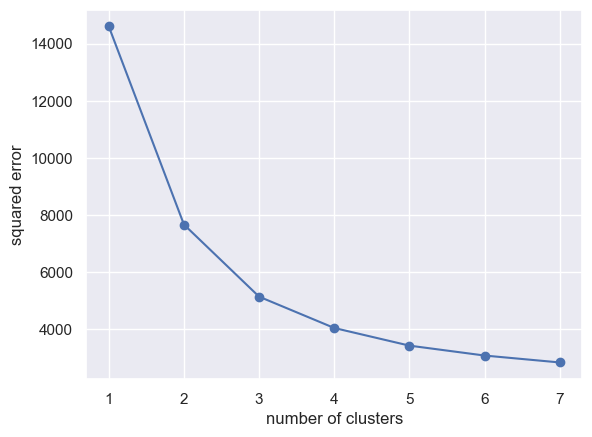

In [17]:
# k-means clustering: using recency, frequency, and monetary as clustering variables

from sklearn.preprocessing import MinMaxScaler

# step 1: standardize data
df_RFM3=df_RFM2.drop(columns=['user_id'])
scaler = MinMaxScaler()
X = scaler.fit_transform(df_RFM3)

# step 2: find the optimal number of clusters
SSE=[]
for i in range(1,8,1):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X)
    SSE.append(kmeans.inertia_)
sns.set()
plt.plot(range(1,8,1),SSE,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('squared error');


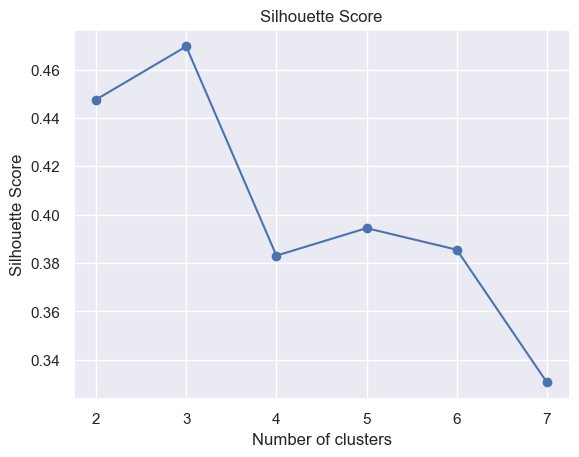

In [18]:
# step 2: find the optimal number of clusters
from joblib import Parallel, delayed

# Define a function to compute silhouette scores for a given number of clusters
def compute_silhouette_score(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    labels = kmeans.labels_
    return silhouette_score(X, labels)

# Parallelize the computation for different numbers of clusters
num_clusters = range(2, 8)
silhouette_scores = Parallel(n_jobs=-1)(delayed(compute_silhouette_score)(n) for n in num_clusters)

# Plot the silhouette scores
plt.plot(num_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()


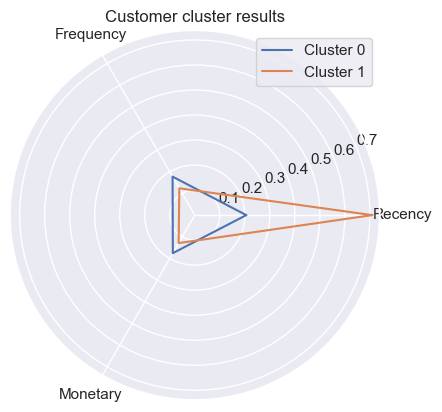

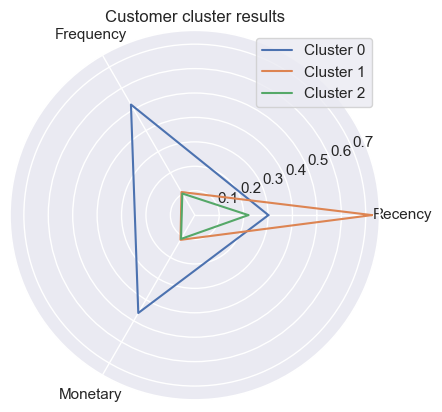

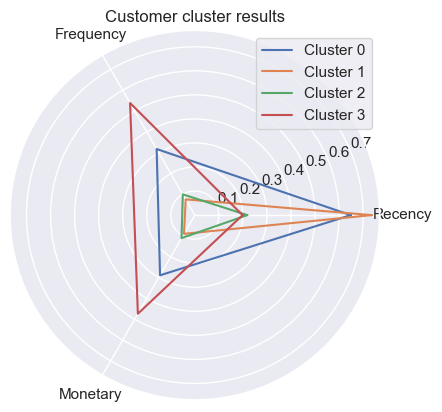

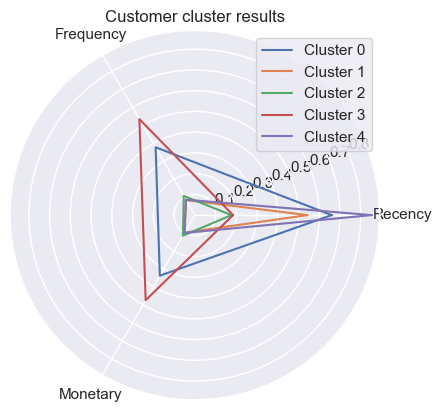

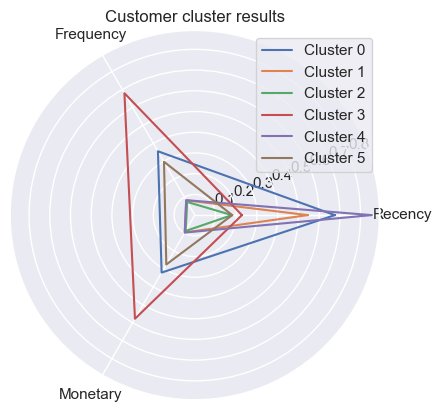

In [19]:
k = list(range(2,7))
column_names = df_RFM3.columns.tolist()

for i in k:
  kmeans = KMeans(n_clusters = i,random_state=0)
  fit_kmeans = kmeans.fit(X)
  centers = kmeans.cluster_centers_
  center_column = column_names

  plt.figure()

#   plt.rcParams['font.sans-serif'] = 'SimHei'
  plt.rcParams['axes.unicode_minus'] = False


  datalength = X.shape[1]
  angle = np.linspace(0, 2 * np.pi, datalength, endpoint=False)
  angle = np.concatenate((angle, [angle[0]]), axis=0)

  centers = np.concatenate((centers, centers[:, 0:1]), axis=1)

  for i in range(centers.shape[0]):
    plt.polar(angle, centers[i, :])
                            
  plt.title('Customer cluster results')

  plt.xticks(angle[:-1], center_column)

  plt.legend(['Cluster 0','Cluster 1','Cluster 2','Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7'], loc='best')

  plt.show()


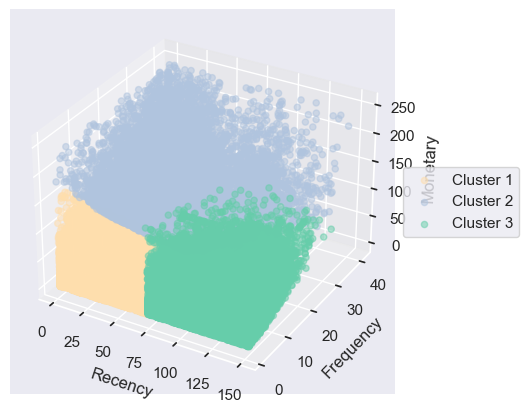

In [20]:
# k-means clustering: using recency, frequency, and monetary as clustering varaibles

# step 3: group customers into 3 clusters
random.seed(8)
km=KMeans(n_clusters=3,random_state=0)
km.fit(X)
random.seed(8)
pred=km.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4: visualize the 3 clusters

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# data preparation
df_RFM2['clusters'] = pred
df_RFM2['clusters'] = df_RFM2['clusters'].replace({2: 'Cluster 1', 0: 'Cluster 2', 1: 'Cluster 3'})
cluster_orders = ['Cluster 1', 'Cluster 2', 'Cluster 3']
cluster_colors = ['navajowhite', 'lightsteelblue', 'mediumaquamarine', 'thistle']
# 3D scatter plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(cluster_orders)):
    x = df_RFM2.loc[df_RFM2['clusters']==cluster_orders[i], 'Recency']
    y = df_RFM2.loc[df_RFM2['clusters']==cluster_orders[i], 'Frequency']
    z = df_RFM2.loc[df_RFM2['clusters']==cluster_orders[i], 'Monetary']
    ax.scatter(x, y, z, c=cluster_colors[i], marker='o', alpha=0.5, label=cluster_orders[i])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [22]:
# step 3: group customers into 3 clusters
random.seed(8)
km=KMeans(n_clusters=3,random_state=0)
km.fit(X)
random.seed(8)
pred=km.predict(X)
df_RFM2=df_RFM2.assign(clusters=pred)

# step 4_1: data preparation
R=[]
F=[]
M=[]
mycolors=['lightsteelblue','mediumaquamarine','thistle']
cluster_orders=[2,0,1]
for i in [0,1,2]:
    R.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Recency'].values.tolist())
    F.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Frequency'].values.tolist())
    M.append(df_RFM2.loc[df_RFM2.clusters==cluster_orders[i],'Monetary'].values.tolist())


C:\Users\nazwa\AppData\Local\Temp\ipykernel_3704\733384807.py:7: FutureWarning: The provided callable <function median at 0x0000019FF261ED40> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_RFM3=df_RFM2.groupby('segments').agg(Recency=('Recency',np.median),Frequency=('Frequency',np.median),Monetary=('Monetary',np.median),MonetarySum=('Monetary',np.sum),size=("clusters",'size'))
C:\Users\nazwa\AppData\Local\Temp\ipykernel_3704\733384807.py:7: FutureWarning: The provided callable <function median at 0x0000019FF261ED40> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_RFM3=df_RFM2.groupby('segments').agg(Recency=('Recency',np.median),Frequency=('Frequency',np.median),Monetary=('Monetary',np.median),MonetarySum=('Monetary',np.sum

         segments  Recency  Frequency  Monetary  MonetarySum   size  \
0         At-Risk    108.0        4.0    22.380   1509087.26  50987   
1  Loyal Customer     32.0        4.0    22.600   1291646.12  45298   
2   New Customers     38.0       21.0   107.245   1311294.24  11222   

   Sales/Customer  
0              30  
1              29  
2             117  


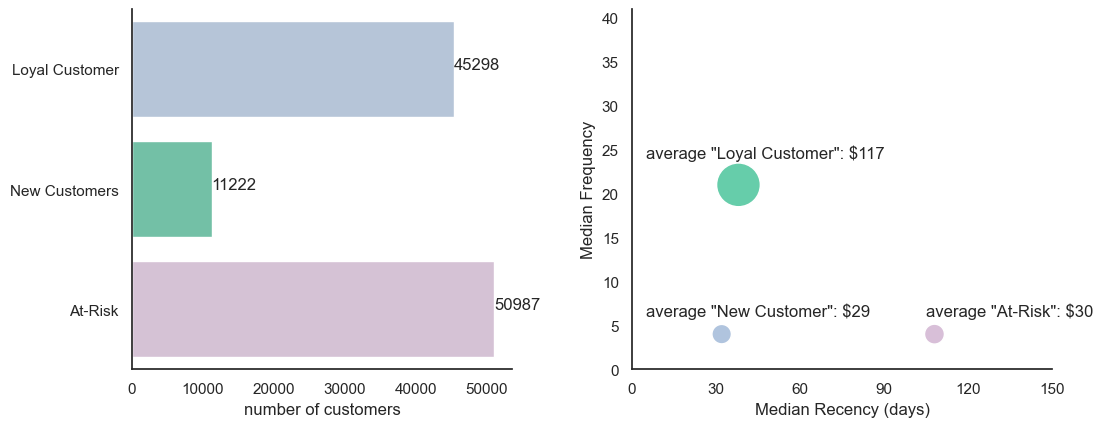

In [25]:
# replace k-means cluster names with more meaningful names
d1={0:"New Customers", 2:"Loyal Customer", 1: "At-Risk"}
df_RFM2.loc[:,"segments"]=df_RFM2.loc[:,"clusters"].map(d1)

# calculate the number of customers, median recency, median frequency, 
# and average customer spend in each customer segment
df_RFM3=df_RFM2.groupby('segments').agg(Recency=('Recency',np.median),Frequency=('Frequency',np.median),Monetary=('Monetary',np.median),MonetarySum=('Monetary',np.sum),size=("clusters",'size'))
df_RFM3.loc[:,'Sales/Customer']=round(df_RFM3.loc[:,'MonetarySum']/df_RFM3.loc[:,'size'])
df_RFM3=df_RFM3.astype({'Sales/Customer':int}).reset_index()
print(df_RFM3)

# visualize
plt.figure(figsize=(10,4))
seg_names=['Loyal Customer','New Customers','At-Risk']

# plot the number of customers in each segment
sns.set_style("white")
plt.axes([0, 0, 0.38, 0.9])
seg=df_RFM2.groupby('segments').size().to_frame().rename(columns={0:'number of customers'}).reset_index()
sns.barplot(x='number of customers',y='segments',data=seg,order=seg_names,palette=mycolors)
for i in [0,1,2]:
    number = seg.loc[seg.segments==seg_names[i], 'number of customers'].item()
    x_pos=round(number,-2)
    plt.text(x_pos,i,number)
plt.ylabel("")
sns.despine()

# plot recency, frequency, and average spend/customer of the 4 segments
plt.axes([0.5,0,0.42,0.9])
sns.scatterplot(x='Recency',y='Frequency',hue='segments',hue_order=seg_names,palette=mycolors,size='Sales/Customer',sizes=(200,1000),legend=False,data=df_RFM3)
plt.ylim(0,41)
plt.xticks(np.arange(0,151,30))
plt.text(5,24,'average "Loyal Customer": $117')
plt.text(5,6,'average "New Customer": $29')
plt.text(105,6,'average "At-Risk": $30')
plt.xlabel('Median Recency (days)')
plt.ylabel('Median Frequency')
sns.despine()
